In [1]:
%%capture
!pip install yfinance

# Momentum strategies

### Download data
We use GOOG  (2010-2021) as an example 

In [2]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

try:
    import yfinance
    print("module 'yfinance' is installed")
except ModuleNotFoundError:
    print("module 'yfinance' is not installed")
    !pip install yfinance
import yfinance as yf

start_date = '2010-01-01'
end_date = '2021-12-31'
ticker='GOOG'

df=yf.download(ticker, start_date, end_date)

module 'yfinance' is installed
[*********************100%***********************]  1 of 1 completed


### We implement the "moving average crossover" strategy 
#### To limit the number of switches, one use an additional moving average: shor-term MA & long-term MA
We want to set a buy signal (=1) when the short-term MA crosses long-term from below, and a sell signal (-1) when it crosses from above

In [3]:
def double_moving_average(financial_data, short_window, long_window):
    signals = pd.DataFrame(index=financial_data.index)
    signals['signal'] = 0.0
    signals['short_mavg'] = financial_data['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = financial_data['Close'].rolling(window=long_window,min_periods=1, center=False).mean()
    signals['signal'][short_window:] =\
        np.where(signals['short_mavg'][short_window:]
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)
    signals['orders'] = signals['signal'].diff()  
    return signals

#When short_window=1, it reduces to the single MA case

#### Use 20 days MV for short term and 100 day MV for long-term
#### To visualize the signals, we put '^' for crossover from below, and 'v' from crossover from above

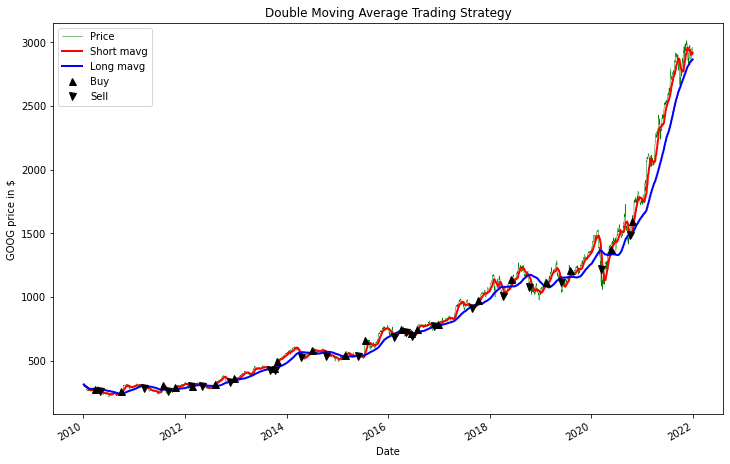

In [4]:
ts=double_moving_average(df,20,100)

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111, ylabel=f'{ticker} price in $')

df["Adj Close"].plot(ax=ax1, color='g', lw=.5)
ts["short_mavg"].plot(ax=ax1, color='r', lw=2.)
ts["long_mavg"].plot(ax=ax1, color='b', lw=2.)

ax1.plot(ts.loc[ts.orders== 1.0].index,
         df["Adj Close"][ts.orders == 1.0],
         '^', markersize=7, color='k')

ax1.plot(ts.loc[ts.orders== -1.0].index,
         df["Adj Close"][ts.orders == -1.0],
         'v', markersize=7, color='k')

plt.legend(["Price","Short mavg","Long mavg","Buy","Sell"])
plt.title("Double Moving Average Trading Strategy")
plt.show()

# Backtesting the strategy
- You are going to set your initial amount of money
- Create a new dataframe positions (the index is still the same as signals)
- Buy 10 shares when signal is 1 and sell 10 shares when signal is -1 
- Calculate the notional (quantity x price) for the portfolio. We multiply Adj Close from the dataframe containing prices and the positions (10 shares)
- Store it into the variable portfolio
- Add `holdings` to portfolio
- Store positions.diff into pos_diff
- Add a column cash in the dataframe portfolio which will calculate the amount of cash we have
- Add a column total to your portfolio calculating the part of holding and the part of cash

            STOCK  holdings          cash         total  returns
Date                                                            
2010-01-04    NaN       0.0  10000.000000  10000.000000      NaN
2010-01-05    0.0       0.0  10000.000000  10000.000000      0.0
2010-01-06    0.0       0.0  10000.000000  10000.000000      0.0
2010-01-07    0.0       0.0  10000.000000  10000.000000      0.0
2010-01-08    0.0       0.0  10000.000000  10000.000000      0.0
...           ...       ...           ...           ...      ...
2021-12-23    0.0       0.0  12056.435242  12056.435242      0.0
2021-12-27    0.0       0.0  12056.435242  12056.435242      0.0
2021-12-28    0.0       0.0  12056.435242  12056.435242      0.0
2021-12-29    0.0       0.0  12056.435242  12056.435242      0.0
2021-12-30    0.0       0.0  12056.435242  12056.435242      0.0

[3020 rows x 5 columns]
Prtfolio final value:    12056.435241699219


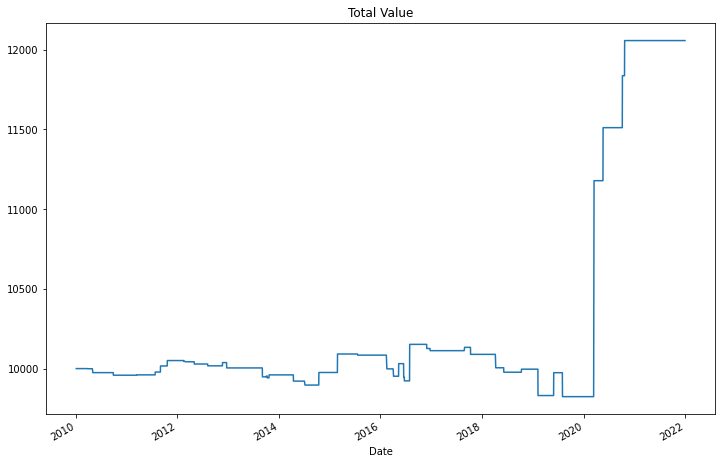

In [5]:

# to invest --- here it is 10,000
initial_capital = float(10000.0)

# You are going to create a new dataframe positions
# Remember the index is still the same as signals
positions = pd.DataFrame(index=ts.index).fillna(0.0)

# dataframe positions
positions['STOCK'] = 10 * ts['orders']

portfolio = positions.multiply(df['Adj Close'], axis=0)

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(df['Adj Close'], axis=0)).sum(axis=1)

# store positions.diff into pos_diff
pos_diff = positions.diff()

# initial_capital - (the notional you use for your different buy/sell)
portfolio['cash'] = initial_capital - (pos_diff.multiply(df['Adj Close'], axis=0)).sum(axis=1).cumsum()

# Add a column total to the portfolio calculating the part of holding and the part of cash
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio)
portfolio['total'].plot(title='Total Value',figsize=(12, 8))
print('Prtfolio final value:   ',  portfolio['total'][-1])

# Naive momentum trading strategy
### If price has gone up in nb_conseq_days consecutive days, buy signal 1
### If price has gone up in nb_conseq_days consecutive days, sell signal -1

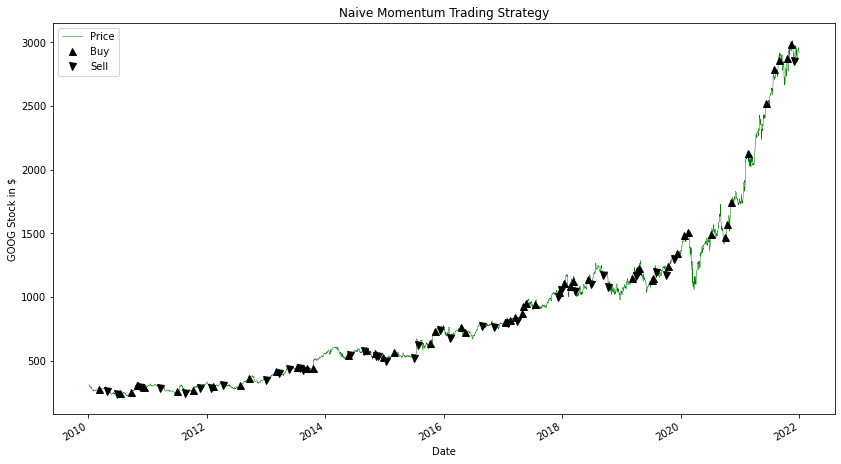

In [6]:
def naive_momentum_trading(financial_data, nb_conseq_days):
    signals = pd.DataFrame(index=financial_data.index)
    signals['orders'] = 0
    cons_day=0
    prior_price=0
    for k in range(len(financial_data['Adj Close'])):
        price=financial_data['Adj Close'][k]
        if k==0:
            prior_price=price
        elif price>prior_price:
            if cons_day<0:
                cons_day=0
            cons_day+=1
        elif price<prior_price:
            if cons_day>0:
                cons_day=0
            cons_day-=1
        if cons_day==nb_conseq_days:
            signals['orders'][k]=1
        elif cons_day == -nb_conseq_days:
            signals['orders'][k]=-1
        prior_price=price
    return signals


ts=naive_momentum_trading(df, 5)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(111, ylabel=f'{ticker} Stock in $')
df["Adj Close"].plot(ax=ax1, color='g', lw=.5)

ax1.plot(ts.loc[ts.orders== 1.0].index,
         df["Adj Close"][ts.orders == 1],
         '^', markersize=7, color='k')

ax1.plot(ts.loc[ts.orders== -1.0].index,
         df["Adj Close"][ts.orders == -1],
         'v', markersize=7, color='k')

plt.legend(["Price","Buy","Sell"])
plt.title("Naive Momentum Trading Strategy")

plt.show()


## Backtesting the strategy

            STOCK  holdings          cash         total  returns
Date                                                            
2010-01-04    0.0       0.0  10000.000000  10000.000000      NaN
2010-01-05    0.0       0.0  10000.000000  10000.000000      0.0
2010-01-06    0.0       0.0  10000.000000  10000.000000      0.0
2010-01-07    0.0       0.0  10000.000000  10000.000000      0.0
2010-01-08    0.0       0.0  10000.000000  10000.000000      0.0
...           ...       ...           ...           ...      ...
2021-12-23    0.0       0.0   9002.477417   9002.477417      0.0
2021-12-27    0.0       0.0   9002.477417   9002.477417      0.0
2021-12-28    0.0       0.0   9002.477417   9002.477417      0.0
2021-12-29    0.0       0.0   9002.477417   9002.477417      0.0
2021-12-30    0.0       0.0   9002.477417   9002.477417      0.0

[3020 rows x 5 columns]
Prtfolio final value:    9002.477416992188


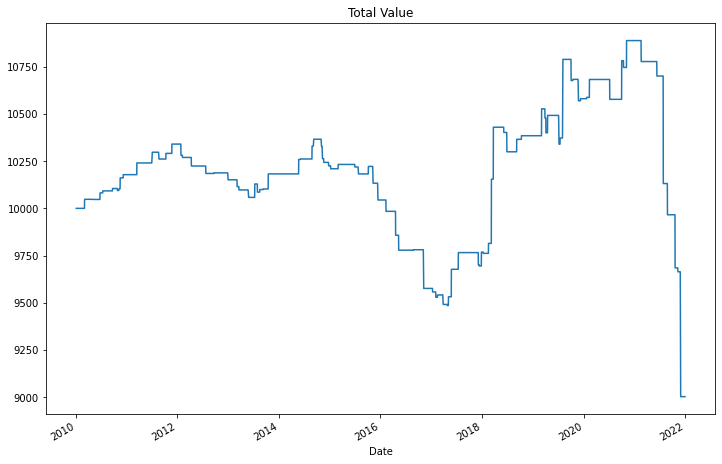

In [7]:
# to invest --- here it is 10,000
initial_capital = float(10000.0)

# You are going to create a new dataframe positions
# Remember the index is still the same as signals
positions = pd.DataFrame(index=ts.index).fillna(0.0)

# dataframe positions
positions['STOCK'] = 10 * ts['orders']

portfolio = positions.multiply(df['Adj Close'], axis=0)

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(df['Adj Close'], axis=0)).sum(axis=1)

# store positions.diff into pos_diff
pos_diff = positions.diff()

# initial_capital - (the notional you use for your different buy/sell)
portfolio['cash'] = initial_capital - (pos_diff.multiply(df['Adj Close'], axis=0)).sum(axis=1).cumsum()

# Add a column total to the portfolio calculating the part of holding and the part of cash
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio)
portfolio['total'].plot(title='Total Value',figsize=(12, 8))

print('Prtfolio final value:   ',  portfolio['total'][-1])

# Turtle strategy
- This system took a slightly longer approach (though by no means a long-term strategy). 
- The signal to enter using this system, for a long position, was when the current price exceeded the high of the previous 55 days. 
- For a short position, the signal to enter was when the price dipped below the low of the last 55 days. 
- Unlike before, the signal to enter the market applied whether the preceding breakout was a winner. 
- The signal to exit was when the price hit a 20-day low (for long positions) or high (for short positions).

#### We make some modification: for long position, exit when the below 55-day average (loss), or when above 20-day max (profit). Treat short position accordingly

In [8]:
def turtle_trading(financial_data, window_size, exit_window):
    signals = pd.DataFrame(index=financial_data.index)
    signals['orders'] = 0

    # window_size-days high
    signals['high'] = financial_data['Adj Close'].shift(1).rolling(window=window_size).max()
    # window_size-days low
    signals['low'] = financial_data['Adj Close'].shift(1).rolling(window=window_size).min()
    # window_size-days mean
    signals['avg'] = financial_data['Adj Close'].shift(1).rolling(window=window_size).mean()
    
    signals['exit_max'] = financial_data['Adj Close'].shift(1).rolling(window=exit_window).max()

    signals['exit_min'] = financial_data['Adj Close'].shift(1).rolling(window=exit_window).min()
        
    # trading rule : stock price > the higest value for window_size day -> buy
    #              stock price < the lowest value for window_size day   -> short

    signals['long_entry'] = financial_data['Adj Close'] > signals.high 
    signals['short_entry'] = financial_data['Adj Close'] < signals.low

    #exit rule : the stock price crosses the mean of past window_size days.

    signals['long_exit'] = (financial_data['Adj Close'] < signals.avg) | (financial_data['Adj Close'] > signals.exit_max)
    signals['short_exit'] = (financial_data['Adj Close'] > signals.avg) | (financial_data['Adj Close'] < signals.exit_min)
 
    position=0
    for k in range(len(signals)):
        if signals['long_entry'][k] and position==0:
            signals.orders.values[k] = 1
            position=1
        elif signals['short_entry'][k] and position==0:
            signals.orders.values[k] = -1
            position=-1
        elif signals['short_exit'][k] and position>0:
            signals.orders.values[k] = -1
            position = 0
        elif signals['long_exit'][k] and position < 0:
            signals.orders.values[k] = 1
            position = 0
        else:
            signals.orders.values[k] = 0
    return signals

## Plot the signals

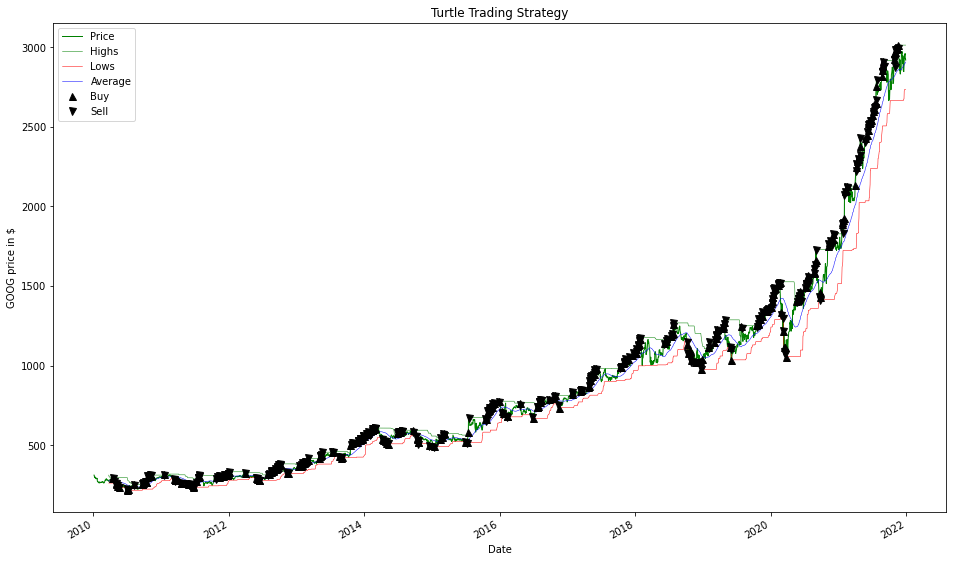

Prtfolio final value:    9002.477416992188


In [9]:
ts=turtle_trading(df,55, 20)

fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(111, ylabel=f'{ticker} price in $')
df["Adj Close"].plot(ax=ax1, color='g', lw=1)
ts["high"].plot(ax=ax1, color='g', lw=.5)
ts["low"].plot(ax=ax1, color='r', lw=.5)
ts["avg"].plot(ax=ax1, color='b', lw=.5)


ax1.plot(ts.loc[ts.orders== 1.0].index,
         df["Adj Close"][ts.orders == 1.0],
         '^', markersize=7, color='k')

ax1.plot(ts.loc[ts.orders== -1.0].index,
         df["Adj Close"][ts.orders == -1.0],
         'v', markersize=7, color='k')

plt.legend(["Price","Highs","Lows","Average","Buy","Sell"])
plt.title("Turtle Trading Strategy")
plt.show()

print('Prtfolio final value:   ',  portfolio['total'][-1])

In [10]:
#ts.to_csv('gooooogle-ts.csv')
ts

,orders,high,low,avg,exit_max,exit_min,long_entry,short_entry,long_exit,short_exit
Date,,,,,,,,,,
2010-01-04,0,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2010-01-05,0,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2010-01-06,0,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2010-01-07,0,NaN,NaN,NaN,NaN,NaN,False,False,False,False
2010-01-08,0,NaN,NaN,NaN,NaN,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
2021-12-23,0,3014.179932,2734.26001,2896.220552,2974.409912,2832.360107,False,False,False,True
2021-12-27,0,3014.179932,2734.26001,2899.780007,2974.409912,2832.360107,False,False,False,True
2021-12-28,0,3014.179932,2734.26001,2903.008554,2974.409912,2832.360107,False,False,False,True


## Backtesting the strategy

            STOCK  holdings          cash         total  returns
Date                                                            
2010-01-04    0.0       0.0  10000.000000  10000.000000      NaN
2010-01-05    0.0       0.0  10000.000000  10000.000000      0.0
2010-01-06    0.0       0.0  10000.000000  10000.000000      0.0
2010-01-07    0.0       0.0  10000.000000  10000.000000      0.0
2010-01-08    0.0       0.0  10000.000000  10000.000000      0.0
...           ...       ...           ...           ...      ...
2021-12-23    0.0       0.0  14778.470459  14778.470459      0.0
2021-12-27    0.0       0.0  14778.470459  14778.470459      0.0
2021-12-28    0.0       0.0  14778.470459  14778.470459      0.0
2021-12-29    0.0       0.0  14778.470459  14778.470459      0.0
2021-12-30    0.0       0.0  14778.470459  14778.470459      0.0

[3020 rows x 5 columns]
Prtfolio final value:    14778.470458984375


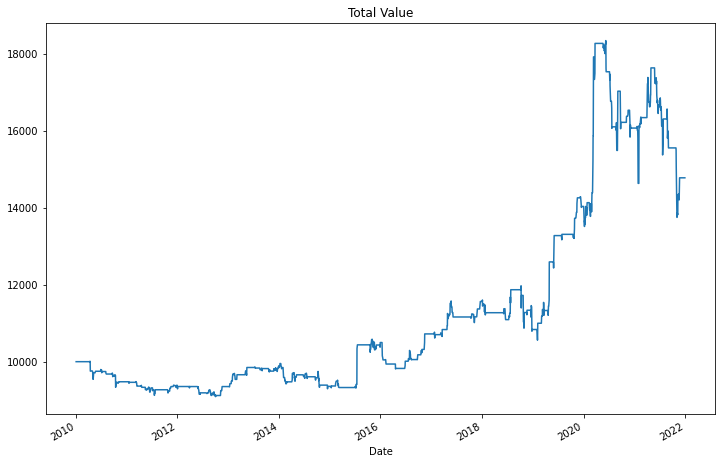

In [11]:
# to invest --- here it is 10,000
initial_capital = float(10000.0)

# You are going to create a new dataframe positions
# Remember the index is still the same as signals
positions = pd.DataFrame(index=ts.index).fillna(0.0)

# dataframe positions
positions['STOCK'] = 10 * ts['orders']

portfolio = positions.multiply(df['Adj Close'], axis=0)

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(df['Adj Close'], axis=0)).sum(axis=1)

# store positions.diff into pos_diff
pos_diff = positions.diff()

# initial_capital - (the notional you use for your different buy/sell)
portfolio['cash'] = initial_capital - (pos_diff.multiply(df['Adj Close'], axis=0)).sum(axis=1).cumsum()

# Add a column total to the portfolio calculating the part of holding and the part of cash
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio)
portfolio['total'].plot(title='Total Value',figsize=(12, 8))

print('Prtfolio final value:   ',  portfolio['total'][-1])